# Static Explorative Data Analysis

In [1]:
from pathlib import Path
import sys
root_dir = Path().resolve().parent
sys.path.append(str(root_dir))



import rsdb.preprocess.data_preprocessing as data_preprocessing
import rsdb.features.featuring as featuring
import gzip
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import random
import warnings
from collections import Counter
import string
import folium
from folium.plugins import MarkerCluster
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', None) # display whole column 

In [2]:
print(Path.cwd().parent.parent)

/Users/guoxuanxu/Documents/local_repo


In [3]:
print("Current Working Directory:", Path.cwd().parent)

Current Working Directory: /Users/guoxuanxu/Documents/local_repo/RSDB


In [4]:
url = "https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/googlelocal/review-California_10.json.gz"
meta_url = "https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/googlelocal/meta-California.json.gz"
# df = data_preprocessing.get_clean_review_data(url, meta_url)

df = data_preprocessing.get_single_chunk(url, meta_url)

Loading metadata from: /Users/guoxuanxu/Documents/local_repo/RSDB/data/metadata.json.gz
Loaded 463034 metadata entries.
Processing review data from: /Users/guoxuanxu/Documents/local_repo/RSDB/data/data.json.gz
Processed 79763 entries in the first chunk.


## Check featuring categories

In [130]:
temp = featuring.featuring_category(df, ['restaurant', 'park', 'store'])
x_temp = temp[['rating', 'isin_category_restaurant', 'isin_category_park', 'isin_category_store']]

x_temp.groupby(['isin_category_restaurant', 'isin_category_park', 'isin_category_store'])['rating'].mean()

isin_category_restaurant  isin_category_park  isin_category_store
0                         0                   0                      4.377424
                                              1                      4.289825
                          1                   0                      4.499492
                                              1                      4.404974
1                         0                   0                      4.259694
                                              1                      4.309434
                          1                   0                      4.274882
                                              1                      4.511834
Name: rating, dtype: float64

In [ ]:

# def category_count(df):
#     """
#     Count the size of the 'category' array for each row in the dataframe
#     and add a new column 'category_count'.

#     Args:
#         df (pd.DataFrame): Input dataframe with a 'category' column containing lists.

#     Returns:
#         pd.DataFrame: The updated dataframe with a new 'category_count' column.
#     """
#     # Ensure 'category' column exists in the DataFrame
#     if 'category' not in df.columns:
#         raise ValueError("The DataFrame must contain a 'category' column.")
    
#     # Calculate the size of the category array for each row
#     df['category_count'] = df['category'].apply(len)
    
#     return df

# temp_x = category_count(df)
# df['rating'].corr(df['category_count'])


# df[['rating', "category_count"]]

## Check Feature: location on rating

In [38]:
def featuring_locations(df: pd.DataFrame, lon_bins=20, lat_bins=20) -> pd.DataFrame:
    """
    takes in a dataframe and divide longitude and latitude into equally
    distributed bins

    Args:
        df: input dataframe
        lon_bins: number of bins for longitude
        lat_bins: number of bins for latitude

    return: dataframe with bins encoded into categories

    """
    assert "longitude" in df.columns, "longitude not in the dataframe"
    assert "latitude" in df.columns, "latitude not in the dataframe"

    # Calculate bin edges for longitude and latitude
    lon_edges = np.linspace(df["longitude"].min(), df["longitude"].max(), lon_bins + 1)
    lat_edges = np.linspace(df["latitude"].min(), df["latitude"].max(), lat_bins + 1)

    lon_bins = pd.cut(
        df["longitude"], bins=lon_edges, labels=False, include_lowest=True
    )
    lat_bins = pd.cut(df["latitude"], bins=lat_edges, labels=False, include_lowest=True)


    return df.assign(lon_bin=lon_bins).assign(lat_bin=lat_bins)

    # lon_feature_df = pd.get_dummies(lon_bins, prefix="lon_bin", dtype=int)
    # lat_feature_df = pd.get_dummies(lat_bins, prefix="lat_bin", dtype=int)

    # return pd.concat([df, lon_feature_df, lat_feature_df], axis=1).drop(
    #     columns=["longitude", "latitude"]
    # )

In [42]:
featuring_locations(df).groupby(['lon_bin', 'lat_bin'])['rating'].mean().sort_values()

lon_bin  lat_bin
8        18         3.736842
17       4          3.840995
18       2          3.920696
17       2          4.025862
7        8          4.028536
                      ...   
14       7          4.767701
11       7          4.777503
13       9          4.850000
19       5          4.850000
12       10         4.861048
Name: rating, Length: 200, dtype: float64

In [28]:
def milliseconds_to_years(milliseconds: int) -> float:
    """
    turn milliseconds into years

    Args:
        milliseconds

    return: number that convert milliseconds into years
    """
    seconds = milliseconds / 1000
    minutes = seconds / 60
    hours = minutes / 60
    days = hours / 24
    years = days / 365.25  # Account for leap years
    return years

def featuring_review_counts(df: pd.DataFrame) -> pd.DataFrame:
    """
    takes in a dataframe and count the average review per year of each gmapid

    Args:
        pd: input dataframe

    return: dataframe with bins encoded into categories
    """
    assert "review_time(unix)" in df.columns, "no review time"
    assert "gmap_id" in df.columns, "needs location identifier"
    assert "num_of_reviews" in df.columns, "needs total review counts"

    latest_review_time = df["review_time(unix)"].max()
    location_earliest_review = df.groupby(["gmap_id"])["review_time(unix)"].min()
    location_duration_ms =  latest_review_time - location_earliest_review
    location_duration_yr = location_duration_ms.apply(milliseconds_to_years)
    location_duration_yr_reviws = df[["gmap_id", "num_of_reviews"]].merge(
        location_duration_yr, left_on="gmap_id", right_index=True
    )

    assert location_duration_yr_reviws.shape[0] == df.shape[0], "merging issue"

    return df.assign(
        **{'avg_review(per year)': location_duration_yr_reviws['num_of_reviews'] / location_duration_yr_reviws['review_time(unix)']}
    )

In [29]:
test = featuring_review_counts(df)

In [38]:
test.columns

Index(['reviewer_id', 'reviewer_name', 'review_time(unix)', 'rating', 'text',
       'resp', 'gmap_id', 'has_rep', 'gmap_name', 'address', 'latitude',
       'longitude', 'description', 'category', 'avg_rating', 'num_of_reviews',
       'price', 'hours', 'MISC', 'relative_results', 'avg_review(per year)'],
      dtype='object')

In [40]:
test['avg_review(per year)'].corr(test['avg_rating'])

0.11880062622428517

In [42]:
df

,reviewer_id,reviewer_name,review_time(unix),rating,text,resp,gmap_id,has_rep,gmap_name,address,latitude,longitude,description,category,avg_rating,num_of_reviews,price,hours,MISC,relative_results
0,1.089912e+20,Song Ro,1609909927056,5,Love there korean rice cake.,None,0x80c2c778e3b73d33:0xbdc58662a4a97d49,False,San Soo Dang,"San Soo Dang, 761 S Vermont Ave, Los Angeles, CA 90005",34.058092,-118.29213,NaN,[Korean restaurant],4.4,18,NaN,"[[Thursday, 6:30AM–6PM], [Friday, 6:30AM–6PM], [Saturday, 6:30AM–6PM], [Sunday, 7AM–12PM], [Monday, Closed], [Tuesday, 6:30AM–6PM], [Wednesday, 6:30AM–6PM]]","{'Service options': ['Takeout', 'Dine-in', 'Delivery'], 'Accessibility': ['Wheelchair accessible entrance'], 'Offerings': ['Comfort food'], 'Amenities': ['Good for kids'], 'Atmosphere': ['Casual']}","[0x80c2c78249aba68f:0x35bf16ce61be751d, 0x80c2c79998f75fff:0xd7ca5c67e96fb778, 0x80c2b899146d7507:0xf4162c12c9cf65f8, 0x80c2c77f2d419951:0x26285631b21e324c, 0x80c2b8add9016015:0x15836f81a963b35f]"
1,1.112903e+20,Rafa Robles,1612849648663,5,Good very good,None,0x80c2c778e3b73d33:0xbdc58662a4a97d49,False,San Soo Dang,"San Soo Dang, 761 S Vermont Ave, Los Angeles, CA 90005",34.058092,-118.29213,NaN,[Korean restaurant],4.4,18,NaN,"[[Thursday, 6:30AM–6PM], [Friday, 6:30AM–6PM], [Saturday, 6:30AM–6PM], [Sunday, 7AM–12PM], [Monday, Closed], [Tuesday, 6:30AM–6PM], [Wednesday, 6:30AM–6PM]]","{'Service options': ['Takeout', 'Dine-in', 'Delivery'], 'Accessibility': ['Wheelchair accessible entrance'], 'Offerings': ['Comfort food'], 'Amenities': ['Good for kids'], 'Atmosphere': ['Casual']}","[0x80c2c78249aba68f:0x35bf16ce61be751d, 0x80c2c79998f75fff:0xd7ca5c67e96fb778, 0x80c2b899146d7507:0xf4162c12c9cf65f8, 0x80c2c77f2d419951:0x26285631b21e324c, 0x80c2b8add9016015:0x15836f81a963b35f]"
2,1.126404e+20,David Han,1583643882296,4,They make Korean traditional food very properly.,None,0x80c2c778e3b73d33:0xbdc58662a4a97d49,False,San Soo Dang,"San Soo Dang, 761 S Vermont Ave, Los Angeles, CA 90005",34.058092,-118.29213,NaN,[Korean restaurant],4.4,18,NaN,"[[Thursday, 6:30AM–6PM], [Friday, 6:30AM–6PM], [Saturday, 6:30AM–6PM], [Sunday, 7AM–12PM], [Monday, Closed], [Tuesday, 6:30AM–6PM], [Wednesday, 6:30AM–6PM]]","{'Service options': ['Takeout', 'Dine-in', 'Delivery'], 'Accessibility': ['Wheelchair accessible entrance'], 'Offerings': ['Comfort food'], 'Amenities': ['Good for kids'], 'Atmosphere': ['Casual']}","[0x80c2c78249aba68f:0x35bf16ce61be751d, 0x80c2c79998f75fff:0xd7ca5c67e96fb778, 0x80c2b899146d7507:0xf4162c12c9cf65f8, 0x80c2c77f2d419951:0x26285631b21e324c, 0x80c2b8add9016015:0x15836f81a963b35f]"
3,1.174403e+20,Anthony Kim,1551938216355,5,Short ribs are very delicious.,None,0x80c2c778e3b73d33:0xbdc58662a4a97d49,False,San Soo Dang,"San Soo Dang, 761 S Vermont Ave, Los Angeles, CA 90005",34.058092,-118.29213,NaN,[Korean restaurant],4.4,18,NaN,"[[Thursday, 6:30AM–6PM], [Friday, 6:30AM–6PM], [Saturday, 6:30AM–6PM], [Sunday, 7AM–12PM], [Monday, Closed], [Tuesday, 6:30AM–6PM], [Wednesday, 6:30AM–6PM]]","{'Service options': ['Takeout', 'Dine-in', 'Delivery'], 'Accessibility': ['Wheelchair accessible entrance'], 'Offerings': ['Comfort food'], 'Amenities': ['Good for kids'], 'Atmosphere': ['Casual']}","[0x80c2c78249aba68f:0x35bf16ce61be751d, 0x80c2c79998f75fff:0xd7ca5c67e96fb778, 0x80c2b899146d7507:0xf4162c12c9cf65f8, 0x80c2c77f2d419951:0x26285631b21e324c, 0x80c2b8add9016015:0x15836f81a963b35f]"
4,1.005808e+20,Mario Marzouk,1494910901933,5,Great food and prices the portions are large,None,0x80c2c778e3b73d33:0xbdc58662a4a97d49,False,San Soo Dang,"San Soo Dang, 761 S Vermont Ave, Los Angeles, CA 90005",34.058092,-118.29213,NaN,[Korean restaurant],4.4,18,NaN,"[[Thursday, 6:30AM–6PM], [Friday, 6:30AM–6PM], [Saturday, 6:30AM–6PM], [Sunday, 7AM–12PM], [Monday, Closed], [Tuesday, 6:30AM–6PM], [Wednesday, 6:30AM–6PM]]","{'Service options': ['Takeout', 'Dine-in', 'Delivery'], 'Accessibility': ['Wheelchair accessible entrance'], 'Offerings': ['Comfort food'], 'Amenities': ['Good f

In [5]:
from rsdb.features.featuring import *


# # Create the new columns
# df['closed_on_weekend'] = df['hours'].apply(lambda x: is_closed_on_weekend(x))
# df['total_hours'] = df['hours'].apply(calculate_total_hours)

test12 = featuring_hours(df)#['is_closed_on_weekend']

In [7]:
featuring_engineering(df)

,review_time(unix),reviewer_id,gmap_id,rating,isin_category_restaurant,isin_category_park,isin_category_store,lon_bin_0,lon_bin_1,lon_bin_2,...,lat_bin_15,lat_bin_16,lat_bin_17,lat_bin_18,lat_bin_19,closed_on_weekend,weekly_operating_hours,time_bin,user_mean_time,prev_item_id
76001,1.322523,1.000046e+20,0x8091aad7a7c4d8f3:0xe4aa0b5a0d2fbcb8,5,0,0,0,0,0,0,...,0,0,0,0,0,False,47.0,1618530640542,0.634746,0x8090504ec98781ad:0xd5235eff697582d1
83574,0.394244,1.000331e+20,0x808fcecafdb31371:0xd9acab442d78ae57,5,0,0,0,0,0,0,...,0,0,0,0,0,False,75.0,1571326062549,0.029116,0x808fcecafdb31371:0x8bd0cb4a080e362f
6436,1.226621,1.000378e+20,0x80c333fe0f143baf:0xd4c005c08bb117d6,2,0,0,0,0,0,0,...,0,0,0,0,0,False,40.0,1613653843231,1.160554,0x80dcac8730afa353:0x51a1d5eebf63f15f
104382,0.493109,1.000383e+20,0x80db7f7d6a9621b1:0x315b053419ed3251,5,0,0,0,0,0,0,...,0,0,0,0,0,NaN,NaN,1576353523343,0.324276,0x80dc83389762f8cf:0x7afc0fbae1154869
98068,-0.507204,1.000410e+20,0x80c3281188d0d8a7:0xd9055ec15e626693,5,0,0,1,0,0,0,...,0,0,0,0,0,False,91.0,1525485867378,-0.539851,0x80dcad120946ced7:0x61926b580ff47c0a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64884,-0.147489,1.184288e+20,0x80c2b66db72fe81b:0xfd5e2f86736d05f4,5,0,0,0,0,0,0,...,0,0,0,0,0,False,70.0,1543777989795,-0.194477,0x80dd33c48f82119f:0xace1cb276e60af3e
103333,1.006453,1.184296e+20,0x80c32fa16dbdf329:0xf8cbe9d0e8fb186c,4,0,0,0,0,0,0,...,0,0,0,0,0,False,76.0,1602457915601,0.369517,0x80c32789715c74dd:0x9c332f98ca8c42cc
7366,-0.291660,1.184301e+20,0x80c2d39636c5d87f:0x3d868d3def90a396,5,0,0,0,0,0,0,...,0,0,0,0,0,False,58.0,1536446661431,-0.523079,0x80c2cf91a4492b67:0xf36a895f62d7c8f5
15246,0.282890,1.184347e+20,0x80c36440129b0c55:0x94d1998653c8f3e9,4,0,0,0,0,0,0,...,0,0,0,0,0,False,37.0,1565663529294,-0.044054,0x80c365d97d417abf:0xdeb65caeafecadfe


In [11]:
test12['weekly_operating_hours'].corr(test12['rating'])

-0.07281954911132175

In [ ]:
# Weekly bins for item bias
data_query["time_bin"] = data_query["review_time(unix)"] // (
    7 * 24 * 3600
)  # same week in same bin

# Mean timestamp for user bias
user_mean_times = data_query.groupby("reviewer_id")["review_time(unix)"].mean()
data_query["user_mean_time"] = data_query["reviewer_id"].map(user_mean_times)


train_df = data_query.sample(frac=0.8, random_state=42)
test_df = data_query.drop(train_df.index)

# Calculate mean and std for normalization
time_mean, time_std = (
    train_df["review_time(unix)"].mean(),
    train_df["review_time(unix)"].std(),
)
user_mean_time_mean, user_mean_time_std = (
    train_df["user_mean_time"].mean(),
    train_df["user_mean_time"].std(),
)

# Normalize the training and test data
train_df["review_time(unix)"] = (train_df["review_time(unix)"] - time_mean) / time_std
test_df["review_time(unix)"] = (test_df["review_time(unix)"] - time_mean) / time_std
train_df["user_mean_time"] = (
    train_df["user_mean_time"] - user_mean_time_mean
) / user_mean_time_std
test_df["user_mean_time"] = (
    test_df["user_mean_time"] - user_mean_time_mean
) / user_mean_time_std


# Sort data by user and timestamp and reate sequences

# sort dataframe and shift the 


data = merged_clean.sort_values(by=["reviewer_id", "review_time(unix)"])
data["prev_item_id"] = data.groupby("reviewer_id")["gmap_id"].shift(1)
data = data.dropna(subset=["prev_item_id"])

In [ ]:


def find_top_words_by_period_sampled(df, column, time_column, periods, sample_size=10000):
    """
    Finds the top 10 most common words for each time period using a sampled subset of the data.

    Args:
        df (DataFrame): Input DataFrame.
        column (str): Column containing the text data.
        time_column (str): Column containing Unix time (in milliseconds).
        periods (list of tuples): List of (start, end) time ranges for filtering.
        sample_size (int): Number of rows to sample for each period. Default is 10,000.

    Returns:
        dict: Dictionary with periods as keys and top 10 words as values.
    """
    # Initialize a dictionary to store results
    top_words_by_period = {}

    # Predefine stopwords and punctuation
    stop_words = set([
        'the', 'and', 'a', 'to', 'of', 'in', 'for', 'on', 'with', 'at', 'it', 'this', 'is', 'from', 'by', 'as', 'that', 'which', 'or', 'an'
        
    ])
    punctuations = set(string.punctuation)

    for start, end in periods:
        # Filter DataFrame for the time period
        period_df = df[(df[time_column] >= start) & (df[time_column] < end)]

        # Sample a subset of the data
        sampled_df = period_df.sample(n=min(sample_size, len(period_df)), random_state=42)

        # Combine all text into one string from the sampled data
        all_text = " ".join(sampled_df[column].dropna().astype(str).tolist())

        # Tokenize words, convert to lowercase, and remove stopwords/punctuation
        words = [
            word.lower() for word in all_text.split()
            if word.lower() not in stop_words and word not in punctuations
        ]

        # Count word frequencies and get the top 10
        word_counts = Counter(words)
        top_words = word_counts.most_common(10)

        # Store results for this period
        top_words_by_period[f"{start}-{end}"] = top_words

    return top_words_by_period


In [36]:
# Define time periods (Unix time in milliseconds)
periods = [
    (1104537600 * 1000, 1262304000 * 1000),  # 2005-2010
    (1262304000 * 1000, 1420070400 * 1000),  # 2010-2015
    (1420070400 * 1000, 1577836800 * 1000),  # 2015-2020
    (1577836800 * 1000, 1704067200 * 1000),  # 2020-2024
]

# Find top words for each period, with sampling
top_words = find_top_words_by_period_sampled(df, column='text', time_column='review_time(unix)', periods=periods, sample_size=10000)

# Print results
for period, words in top_words.items():
    print(f"Top words for {period}:")
    for word, count in words:
        print(f"{word}: {count}")
    print()


Top words for 1104537600000-1262304000000:
i: 2917
was: 1460
they: 1272
but: 1179
you: 1161
my: 1043
are: 913
not: 906
have: 860
food: 803

Top words for 1262304000000-1420070400000:
i: 6605
was: 3822
they: 2683
you: 2523
but: 2441
my: 2310
are: 1962
great: 1851
have: 1839
not: 1605

Top words for 1420070400000-1577836800000:
i: 1978
was: 1303
great: 1250
good: 1151
food: 973
they: 938
very: 842
my: 773
but: 770
you: 754

Top words for 1577836800000-1704067200000:
i: 2267
was: 1580
they: 1107
great: 1093
good: 963
my: 938
very: 919
food: 804
you: 776
are: 727



In [ ]:


def average_rating_maps(df, time_column, rating_column, periods, sample_size=100000, location_column="latitude, longitude"):
    """
    Generates maps showing the average rating of all locations over time.

    Args:
        df (DataFrame): The DataFrame containing the review data.
        time_column (str): Column containing Unix time (in milliseconds).
        rating_column (str): Column containing the review ratings.
        periods (list of tuples): List of (start, end) time ranges for filtering.
        sample_size (int): Number of rows to sample from the entire DataFrame. Default is 100,000.
        location_column (str): Column for the location. Assumes a tuple for (latitude, longitude).
        
    Returns:
        List of Folium Maps for each time period.
    """
    # Sample the dataframe once
    sampled_df = df.sample(n=sample_size, random_state=42)

    # List to store the maps
    maps = []
    
    for i, (start, end) in enumerate(periods):
        # Filter the data for the current period
        period_df = sampled_df[(sampled_df[time_column] >= start) & (sampled_df[time_column] < end)]

        # Group by location (latitude and longitude) and calculate the average rating for each location
        avg_ratings_per_location = period_df.groupby(['latitude', 'longitude'])[rating_column].mean().reset_index()

        # Create a Folium map centered around a mean location
        avg_lat = avg_ratings_per_location['latitude'].mean()
        avg_lon = avg_ratings_per_location['longitude'].mean()
        m = folium.Map(location=[avg_lat, avg_lon], zoom_start=6)

        # Create a marker cluster
        marker_cluster = MarkerCluster().add_to(m)

        # Add a marker for each location with average rating
        for _, row in avg_ratings_per_location.iterrows():
            folium.CircleMarker(
                location=[row['latitude'], row['longitude']],
                radius=5,
                popup=f"Avg Rating: {row[rating_column]:.2f}",
                color='blue',
                fill=True,
                fill_color='blue',
                fill_opacity=0.6
            ).add_to(marker_cluster)
        
        # Title for the map based on the period
        period_label = f"Average Rating (from {pd.to_datetime(start, unit='ms').year} to {pd.to_datetime(end, unit='ms').year})"
        maps.append(m)
        m.save(f"average_rating_map_{i}.html")  # Save map as HTML file
    
    return maps

# Define time periods (Unix time in milliseconds)
periods = [
    (1104537600 * 1000, 1262304000 * 1000),  # 2005-2010
    (1262304000 * 1000, 1420070400 * 1000),  # 2010-2015
    (1420070400 * 1000, 1577836800 * 1000),  # 2015-2020
    (1577836800 * 1000, 1704067200 * 1000),  # 2020-2024
]

# Call the function to generate the maps
maps = average_rating_maps(df, time_column='review_time(unix)', rating_column='avg_rating', periods=periods, sample_size=100000)


In [ ]:


# Sample 1000 entries from the dataframe
df_sample = df.sample(n=1000, random_state=42)

# Extract latitude, longitude, and category for each entry
df_sample['latitude'] = df_sample['latitude']
df_sample['longitude'] = df_sample['longitude']
df_sample['category'] = df_sample['category']

# Create a function to get the most popular category for each location
def get_most_popular_category(location_df):
    # Count the occurrences of each category for a given location
    category_counts = location_df['category'].explode().value_counts()
    if not category_counts.empty:
        return category_counts.idxmax()  # Get the most frequent category
    return None

# Group by location and get the most popular category for each location
location_categories = df_sample.groupby(['latitude', 'longitude']).apply(get_most_popular_category).reset_index(name='most_popular_category')

# Create the map centered around an average location (or any central location)
map_center = [df_sample['latitude'].mean(), df_sample['longitude'].mean()]
mymap = folium.Map(location=map_center, zoom_start=10)

# Add markers for each location with the most popular category
for idx, row in location_categories.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Category: {row['most_popular_category']}",
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(mymap)

# Save the map to an HTML file and display it
mymap.save("most_popular_categories_map.html")

# To display the map inline in Jupyter or similar environments, you can use:
# mymap


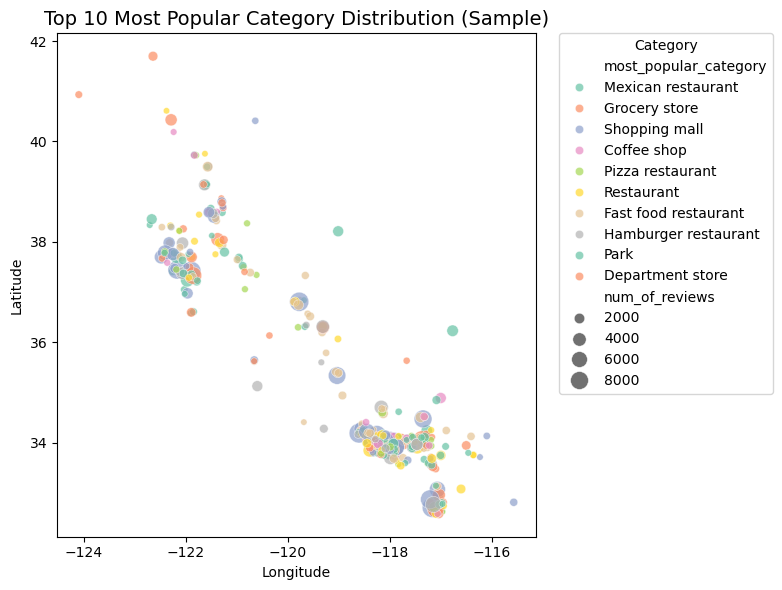

In [ ]:
# Sample 10000 entries from the dataframe
sample_size = 10000
df_sample = df.sample(n=sample_size, random_state=42)

# Define latitude and longitude bounds
lat_min, lat_max = 32.5, 42
long_min, long_max = -124.4, -114.13

# Filter out rows where latitude and longitude are outside the bounds
df_sample_filtered = df_sample[
    (df_sample['latitude'] >= lat_min) & (df_sample['latitude'] <= lat_max) & 
    (df_sample['longitude'] >= long_min) & (df_sample['longitude'] <= long_max)
]

# Create a function to get the most popular category for each location
def get_most_popular_category(location_df):
    # Count the occurrences of each category for a given location
    category_counts = location_df['category'].explode().value_counts()
    if not category_counts.empty:
        return category_counts.idxmax()  # Get the most frequent category
    return None

# Group by location and get the most popular category for each location
location_categories = df_sample_filtered.groupby(['latitude', 'longitude']).apply(get_most_popular_category).reset_index(name='most_popular_category')

# Merge the most_popular_category column back into df_sample_filtered
df_sample_filtered = pd.merge(df_sample_filtered, location_categories, on=['latitude', 'longitude'], how='left')

# Get the top 10 most popular categories
top_categories = df_sample_filtered['most_popular_category'].value_counts().nlargest(10).index

# Filter the dataframe to include only the top 10 categories
df_sample_filtered = df_sample_filtered[df_sample_filtered['most_popular_category'].isin(top_categories)]

# Map each category to a color
category_colors = {category: color for category, color in zip(df_sample_filtered['most_popular_category'].unique(), sns.color_palette("Set2", len(df_sample_filtered['most_popular_category'].unique())))}

# Create the plot (only one subplot for the most popular category distribution)
plt.figure(figsize=(8, 6))

# Scatterplot for Most Popular Category Distribution
sns.scatterplot(
    data=df_sample_filtered,
    x="longitude", 
    y="latitude", 
    hue="most_popular_category", 
    palette=category_colors,
    size="num_of_reviews", 
    sizes=(20, 200), 
    alpha=0.7
)

plt.title('Top 10 Most Popular Category Distribution (Sample)', fontsize=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Move the legend outside the plot
plt.legend(title="Category", loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

# Display the plot
plt.tight_layout()
plt.show()


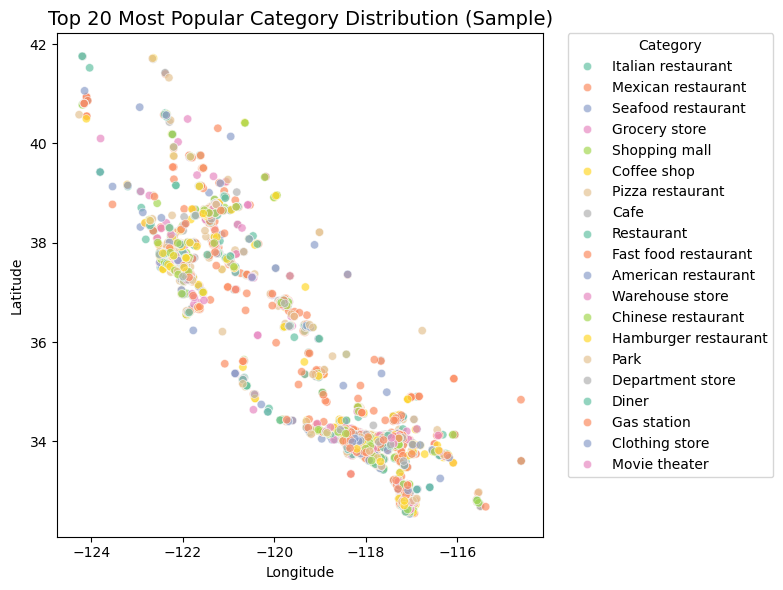

In [68]:

# Sample 10000 entries from the dataframe
sample_size = 10000
df_sample = df.sample(n=sample_size, random_state=42)

# Define latitude and longitude bounds
lat_min, lat_max = 32.5, 42
long_min, long_max = -124.4, -114.13

# Filter out rows where latitude and longitude are outside the bounds
df_sample_filtered = df_sample[
    (df_sample['latitude'] >= lat_min) & (df_sample['latitude'] <= lat_max) & 
    (df_sample['longitude'] >= long_min) & (df_sample['longitude'] <= long_max)
]

# Create a function to get the most popular category for each location
def get_most_popular_category(location_df):
    # Count the occurrences of each category for a given location
    category_counts = location_df['category'].explode().value_counts()
    if not category_counts.empty:
        return category_counts.idxmax()  # Get the most frequent category
    return None

# Group by location and get the most popular category for each location
location_categories = df_sample_filtered.groupby(['latitude', 'longitude']).apply(get_most_popular_category).reset_index(name='most_popular_category')

# Merge the most_popular_category column back into df_sample_filtered
df_sample_filtered = pd.merge(df_sample_filtered, location_categories, on=['latitude', 'longitude'], how='left')

# Get the top 20 most popular categories
top_categories = df_sample_filtered['most_popular_category'].value_counts().nlargest(20).index

# Filter the dataframe to include only the top 20 categories
df_sample_filtered = df_sample_filtered[df_sample_filtered['most_popular_category'].isin(top_categories)]

# Map each category to a color
category_colors = {category: color for category, color in zip(df_sample_filtered['most_popular_category'].unique(), sns.color_palette("Set2", len(df_sample_filtered['most_popular_category'].unique())))}

# Create the plot (only one subplot for the most popular category distribution)
plt.figure(figsize=(8, 6))

# Scatterplot for Most Popular Category Distribution
sns.scatterplot(
    data=df_sample_filtered,
    x="longitude", 
    y="latitude", 
    hue="most_popular_category", 
    palette=category_colors,
    alpha=0.7
)

plt.title('Top 20 Most Popular Category Distribution (Sample)', fontsize=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Move the legend outside the plot
plt.legend(title="Category", loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

# Display the plot
plt.tight_layout()
plt.show()


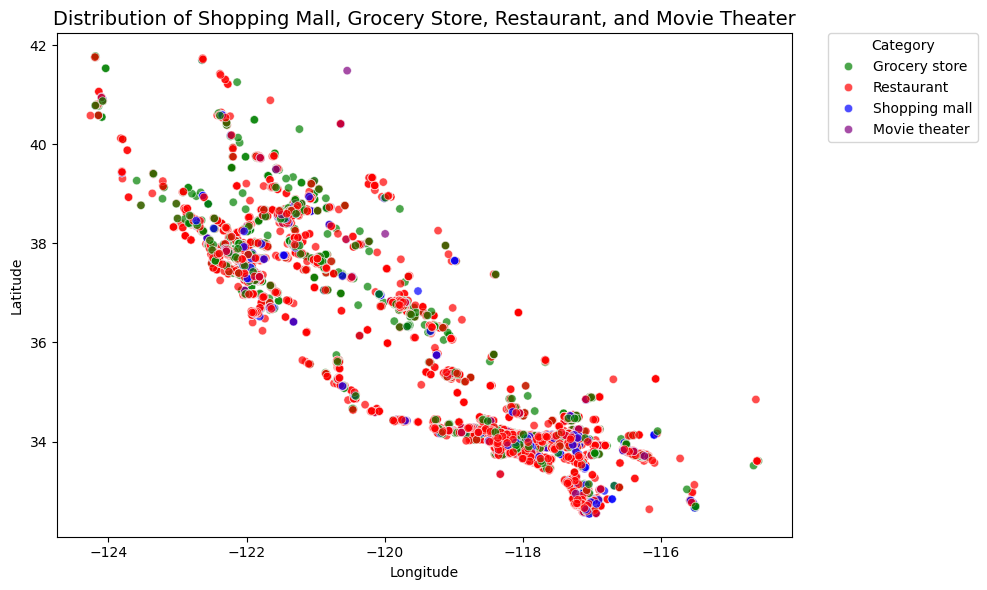

In [ ]:
# Sample 50000 entries from the dataframe
sample_size = 50000
df_sample = df.sample(n=sample_size, random_state=42)

# Define latitude and longitude bounds
lat_min, lat_max = 32.5, 42
long_min, long_max = -124.4, -114.13

# Filter out rows where latitude and longitude are outside the bounds
df_sample_filtered = df_sample[
    (df_sample['latitude'] >= lat_min) & (df_sample['latitude'] <= lat_max) & 
    (df_sample['longitude'] >= long_min) & (df_sample['longitude'] <= long_max)
]

# Filter the dataframe for the selected categories
categories_of_interest = ['Shopping mall', 'Grocery store', 'Restaurant', 'Movie theater']
df_sample_filtered = df_sample_filtered[df_sample_filtered['category'].apply(lambda x: any(cat in categories_of_interest for cat in x))]

# Explode the categories column to work with individual categories
df_sample_filtered_exploded = df_sample_filtered.explode('category')

# Keep only the rows where the category is in the list of interest
df_sample_filtered_exploded = df_sample_filtered_exploded[df_sample_filtered_exploded['category'].isin(categories_of_interest)]

# Create a color palette for the categories
category_colors = {
    'Shopping mall': 'blue',
    'Grocery store': 'green',
    'Restaurant': 'red',
    'Movie theater': 'purple'
}

# Create the plot
plt.figure(figsize=(10, 6))

# Scatterplot for selected categories
sns.scatterplot(
    data=df_sample_filtered_exploded,
    x="longitude", 
    y="latitude", 
    hue="category", 
    palette=category_colors,
    alpha=0.7
)

# Set the title and labels
plt.title('Distribution of Shopping Mall, Grocery Store, Restaurant, and Movie Theater', fontsize=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Move the legend outside the plot
plt.legend(title="Category", loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

# Display the plot
plt.tight_layout()
plt.show()


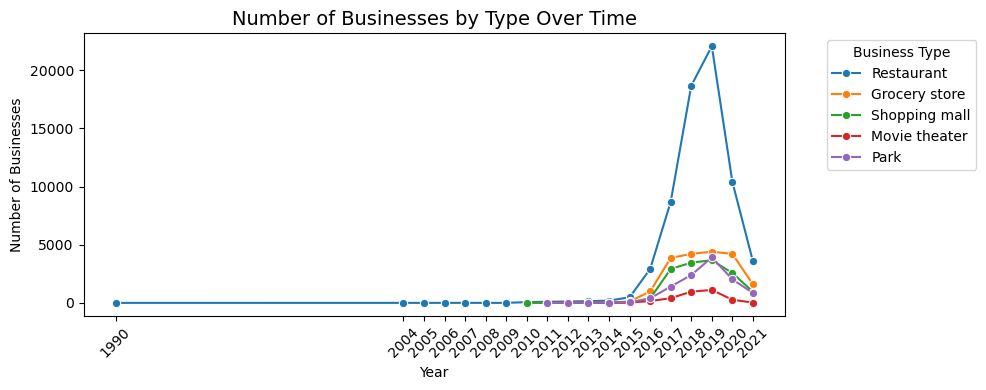

In [83]:
# Sample 1000 entries from the dataframe (adjust the sample size as needed)
sample_size = 300000
df_sample = df.sample(n=sample_size, random_state=42)

# Assuming you have a 'review_time' column or similar that contains datetime or Unix timestamps
# If the column is a Unix timestamp (in milliseconds), we first need to convert it to a datetime object
df_sample['review_time'] = pd.to_datetime(df_sample['review_time(unix)'], unit='ms')

# Extract the year from the 'review_time' column
df_sample['year'] = df_sample['review_time'].dt.year

# Filter the dataset to include only the specific business types we're interested in
business_types = ['Restaurant', 'Shopping mall', 'Park', 'Grocery store', 'Movie theater']
df_sample_filtered = df_sample[df_sample['category'].apply(lambda x: any(business in x for business in business_types))]

# Create a new column that maps the specific business types
def map_business_type(categories):
    for business in business_types:
        if business in categories:
            return business
    return None  # In case no category matches

df_sample_filtered['business_type'] = df_sample_filtered['category'].apply(map_business_type)

# Group by year and business type, then count the number of businesses for each
businesses_per_year_type = df_sample_filtered.groupby(['year', 'business_type']).size().reset_index(name='count')

# Create the line plot
plt.figure(figsize=(10, 4))

# Create a line plot for each business type
sns.lineplot(x='year', y='count', hue='business_type', data=businesses_per_year_type, marker='o')

# Set the title and labels
plt.title('Number of Businesses by Type Over Time', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Number of Businesses')

# Display the legend outside the graph
plt.legend(title="Business Type", bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust x-axis to display every year, not just specific intervals
plt.xticks(businesses_per_year_type['year'].unique(), rotation=45)  # Ensure each year is shown

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
# Step 1: Find unique keys in the dictionaries within the MISC column
unique_keys = set()

# Iterate through each dictionary in the 'MISC' column and collect the keys
for misc_dict in df['MISC']:
    if isinstance(misc_dict, dict):  # Ensure the value is a dictionary
        unique_keys.update(misc_dict.keys())

# Print unique keys
print("Unique keys in MISC:", unique_keys)

# Step 2: Find unique values for each key (handling lists as values)
unique_values = {}

# Iterate through each dictionary again to get unique values for each key
for key in unique_keys:
    # Collect unique values for the current key
    values_for_key = set()
    for misc_dict in df['MISC']:
        if isinstance(misc_dict, dict) and key in misc_dict:
            # Add each item from the list to the set for unique values
            values_for_key.update(misc_dict[key])
    unique_values[key] = values_for_key

# Print the number of unique values for each key
for key, values in unique_values.items():
    print(f"Key: {key} has {len(values)} unique values: {values}")


Unique keys in MISC: {'Payments', 'Health & safety', 'Dining options', 'Health and safety', 'Accessibility', 'Offerings', 'Planning', 'Recycling', 'Getting here', 'Service options', 'Amenities', 'Crowd', 'Highlights', 'Lodging options', 'Popular for', 'Atmosphere', 'From the business', 'Activities'}
Key: Payments has 7 unique values: {'NFC mobile payments', 'Cheques', 'Credit cards', 'Cash-only', 'Cash only', 'Checks', 'Debit cards'}
Key: Health & safety has 8 unique values: {'Appointment required', 'Staff get temperature checks', 'Reservations required', 'Staff wear masks', 'Temperature check required', 'Safety dividers at checkout', 'Staff required to disinfect surfaces between visits', 'Mask required'}
Key: Dining options has 9 unique values: {'Catering', 'Breakfast', 'Dinner', 'Lunch', 'Outside food allowed', 'Pay ahead', 'Counter service', 'Seating', 'Dessert'}
Key: Health and safety has 8 unique values: {'Appointment required', 'Staff get temperature checks', 'Reservations requir

In [ ]:
# Create a separate DataFrame for one-hot encoded columns
one_hot_encoded_df = pd.DataFrame(index=df.index)  # Use the same index as the original df

# Iterate through each row in the dataframe to check for key-value presence
for index, row in df.iterrows():
    if isinstance(row['MISC'], dict):
        for key, values in unique_values.items():
            # For each key, iterate through the possible values
            for value in values:
                # Create a new column name based on key-value
                column_name = f"{key}_{value}"
                
                # Check if the value exists for the key in the dictionary
                if key in row['MISC'] and value in row['MISC'][key]:
                    # If present, set the column to 1
                    one_hot_encoded_df.at[index, column_name] = 1
                else:
                    # If not present, set the column to 0
                    one_hot_encoded_df.at[index, column_name] = 0

# Step 3: Final clean-up: Replace NaN with 0 (since new columns may have NaN values initially)
one_hot_encoded_df = one_hot_encoded_df.fillna(0)

# Now, one_hot_encoded_df contains the one-hot encoded columns
print(one_hot_encoded_df.head())  # See the result